# DOC07
## Problema 1

Los vectores en ECi son:

In [1]:
import numpy as np

ne_i = np.array([-1e0, 0e0, 0e0])
ns_i = np.array([0e0, 1e0, 0e0])

Los vectores en Bosy son:

In [2]:
from math import sqrt

ne_b = np.array([-1e0, 1e0, 0e0]) * sqrt(2e0) / 2e0
ns_b = np.array([1e0, 1e0, 0e0]) * sqrt(2e0) / 2e0

La matriz, por TRIAD:

In [3]:
from doc.attitude import triad

c_triad = triad(ui=ne_i, ub=ne_b, vi=ns_i, vb=ns_b)

print(c_triad)

[[ 0.70710678  0.70710678  0.        ]
 [-0.70710678  0.70710678  0.        ]
 [ 0.          0.          1.        ]]


La matriz, por q-method, con mismos pesos:

In [4]:
from doc.attitude import q_method

c_q = q_method(vbs=[ne_b, ns_b], vis=[ne_i, ns_i], ws=[1e0, 1e0])

print(c_q)

[[ 0.70710678  0.70710678  0.        ]
 [-0.70710678  0.70710678  0.        ]
 [ 0.          0.          1.        ]]


La matriz, por quest, con mismos pesos:

In [5]:
from doc.attitude import quest

c_quest = quest(vbs=[ne_b, ns_b], vis=[ne_i, ns_i], ws=[0.1, 0.2])

print(c_quest)

[[ 0.70710678  0.70710678  0.        ]
 [-0.70710678  0.70710678  0.        ]
 [ 0.          0.          1.        ]]


Al tener solo dos medidas, da igual el peso :).

## Problema 2

Los dos vectores, $v_1$ y $v_2$, en ejes Body e Inerciales son:

In [6]:
v1_b = np.array([.8273, .5541, -.0920])
v2_b = np.array([-.8285, .5522, -.0955])

v1_i = np.array([-.1517, -.9669, .2050])
v2_i = np.array([-.8393, .4494, -.3044])

Aplicando TRIAD:

In [7]:
print(triad(ub=v1_b, vb=v2_b, ui=v1_i, vi=v2_i))

[[ 0.41552746 -0.85502654  0.31002605]
 [-0.83386692 -0.49424182 -0.24544815]
 [ 0.36312481 -0.15656487 -0.91848986]]


## Problema 3

Secuencia 3-2-1 con:
* $\theta_{10}=\theta_{x0}=80\ deg$
* $\theta_{20}=\theta_{y0}=30\ deg$
* $\theta_{30}=\theta_{z0}=40\ deg$

Tenemos $\vec\omega(t)$:

$$\vec\omega(t)=5\cdot\left[\begin{array}{c}\sin(0.1\cdot t)\\ 0.01 \\ \cos(0.1\cdot t)\end{array}\right]\ deg/s$$

Integrar 1 minuto.

La ecuación diferencial es:

In [8]:
from math import pi, sin, cos
from doc.kinematics import kin_sec as f_angulos

def f_integrar(u, t):
    angulos = u[0:3]
    omega = np.array([sin(0.1*t), 0.01, cos(0.1*t)]) * 5e0 * pi / 180.
    t1, t2, t3 = angulos[0], angulos[1], angulos[2]
    df_dt = f_angulos(omega, [3, 2, 1], t1, t2, t3)
    return df_dt

Los valores iniciales y parámetros de simulación son:

In [9]:
# Valores iniciales:
u0 =np.array([40e0, 30e0, 80e0])

# Parámetros temporales.
t0 = 0e0  # Tiempo inicial [s].
dt = 1e-2  # Inc. de tiempo [s].
tf = 60.  # Tiempo final [s].

# Parámetros de almacén de soluciones.
n_max = 100  # Número de puntos a guardar.
ts = np.linspace(0e0, tf, n_max)  # Tiempos en los que se guarda valores [s].
us = np.zeros((n_max, 3))  # Almacén de valores del vector de estado u.
us[0, :] = u0  # Almacén del primer valor.

Integro con *RK4*:

In [10]:
from doc.integrators import rk4

rk4(ts, us, f_integrar, dt)

Al final ploteamos el resultado final.

Una cosa, Salvatore numera los ángulos de Euler por su eje:

| Nombre real | Eje de Giro | Nomencatura Salvatore | Nomenclatura Imanol |
|:-----------:|:-----------:|:---------------------:|:-------------------:|
| Yaw         | Z           | $\theta_3$            | $\theta_1$          |
| Pitch       | Y           | $\theta_2$            | $\theta_2$          |
| Roll        | X           | $\theta_1$            | $\theta_3$          |

La de Salvatore es más intuitiva, pero si no son giros 3-2-1, mi nomenclatura te dice que el primer giro se hace con $\theta_1$, luego dos, y tres. Las variables de la leyenda se muestran según **nomenclatura Salvatore**.

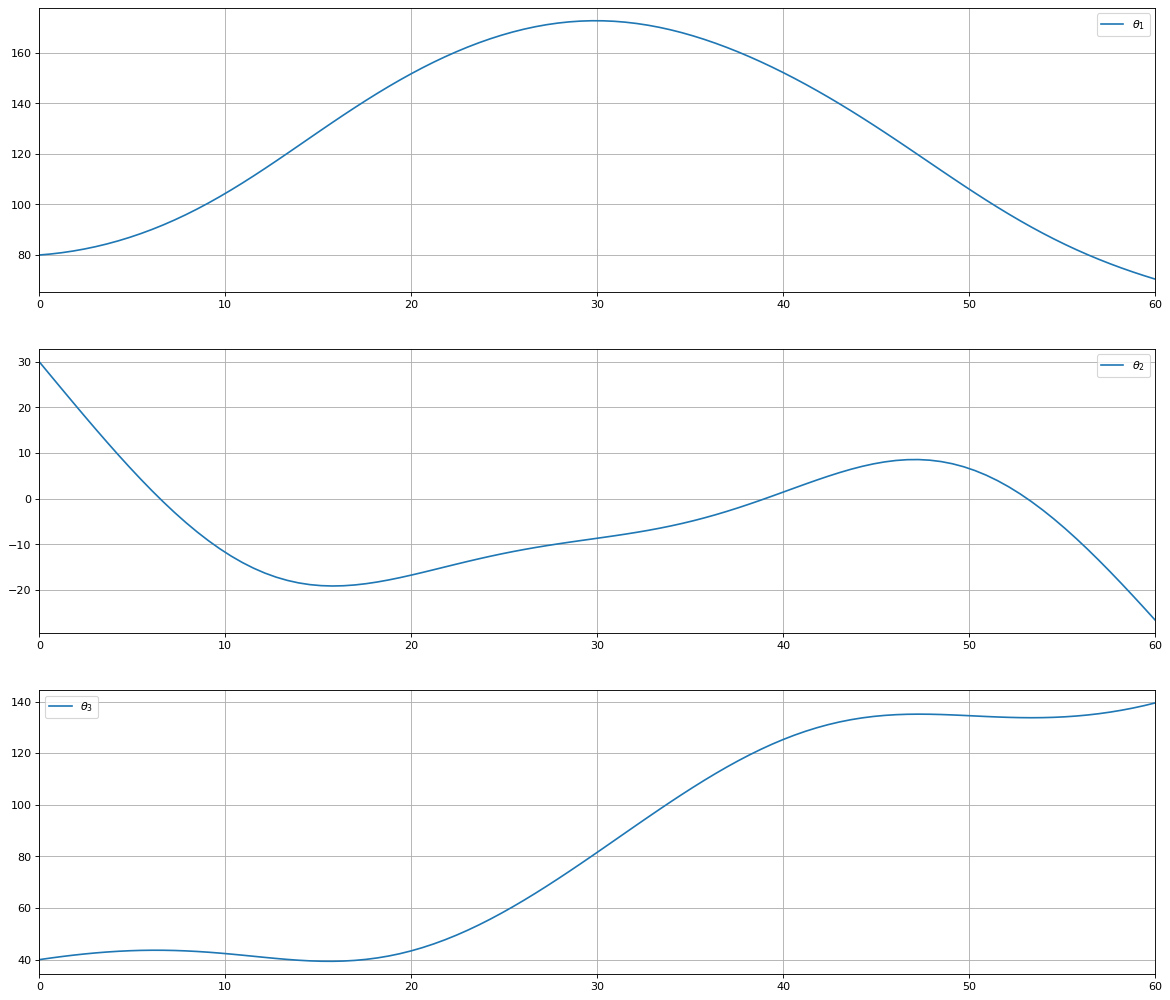

In [11]:
# Para hacer los plots luego
%matplotlib inline
# %matplotlib widget
import matplotlib.pyplot as plt

l = ["$\\theta_3$", "$\\theta_2$", "$\\theta_1$"]

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
fig.subplots(3, 1)

for ii in range(1, 4):
    plt.subplot(3, 1, 4 - ii)
    plt.plot(ts, us[:, ii - 1], label=l[ii-1])
    plt.xlim([0e0, 60e0])
    plt.grid(True)
    plt.legend()
    # plt.title(l[ii-1])
    pass

plt.show()

## Problema 4

Secuencia 3-2-1 con:
* $\theta_{10}=\theta_{x0}=80\ deg$
* $\theta_{20}=\theta_{y0}=30\ deg$
* $\theta_{30}=\theta_{z0}=40\ deg$

Tenemos $\vec\omega(t)$:

$$\vec\omega(t)=50\cdot\left[\begin{array}{c}\sin(0.1\cdot t)\\ 0.01 \\ \cos(0.1\cdot t)\end{array}\right]\ deg/s$$

Integrar 1 minuto, con cuaterniones.

Calculamos el cuaternión inicial:

In [12]:
from doc.kinematics.functions import trsf_sec_generic, cbi2q

sec = [3, 2, 1]
angulos = [40e0, 30e0, 80e0]
c_bi = trsf_sec_generic(sec, angulos)
q0 = cbi2q(c_bi)

print(f"Cuaternión inicial: {q0}")

Cuaternión inicial: [0.51562993 0.39866516 0.09674251 0.75221855]


La ecuación diferencial viene dada por:

In [13]:
from doc.kinematics import kin_q

def f_integrar(u, t):
    omega = np.array([sin(0.1*t), 0.01, cos(0.1*t)]) * 50e0 * pi / 180.
    df_dt = kin_q(omega, u)
    return df_dt

Inicializamos:

In [14]:
# Valores iniciales:
u0 = q0

# Parámetros temporales.
t0 = 0e0  # Tiempo inicial [s].
dt = 1e-2  # Inc. de tiempo [s].
tf = 60.  # Tiempo final [s].

# Parámetros de almacén de soluciones.
n_max = 100  # Número de puntos a guardar.
ts = np.linspace(0e0, tf, n_max)  # Tiempos en los que se guarda valores [s].
us = np.zeros((n_max, 4))  # Almacén de valores del vector de estado u.
us[0, :] = u0  # Almacén del primer valor.

Integramos:

In [15]:
rk4(ts, us, f_integrar, dt)

Ploteamos:

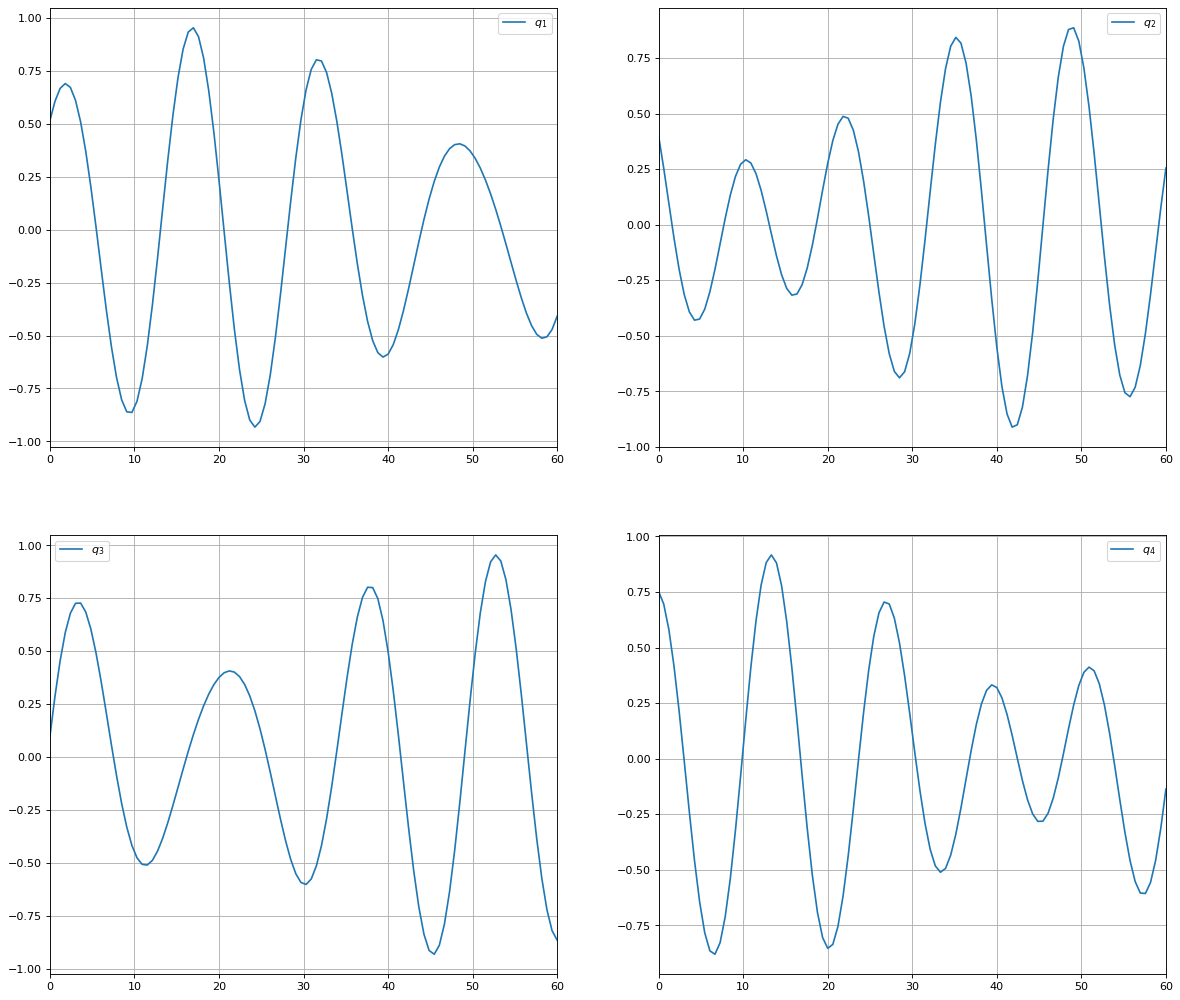

In [16]:
l = ["$q_1$", "$q_2$", "$q_3$", "$q_4$"]

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
fig.subplots(3, 1)

for ii in range(1, 5):
    plt.subplot(2, 2, ii)
    plt.plot(ts, us[:, ii - 1], label=l[ii-1])
    plt.xlim([0e0, 60e0])
    plt.grid(True)
    plt.legend()
    # plt.title(l[ii-1])
    pass

plt.show()

Y la norma:

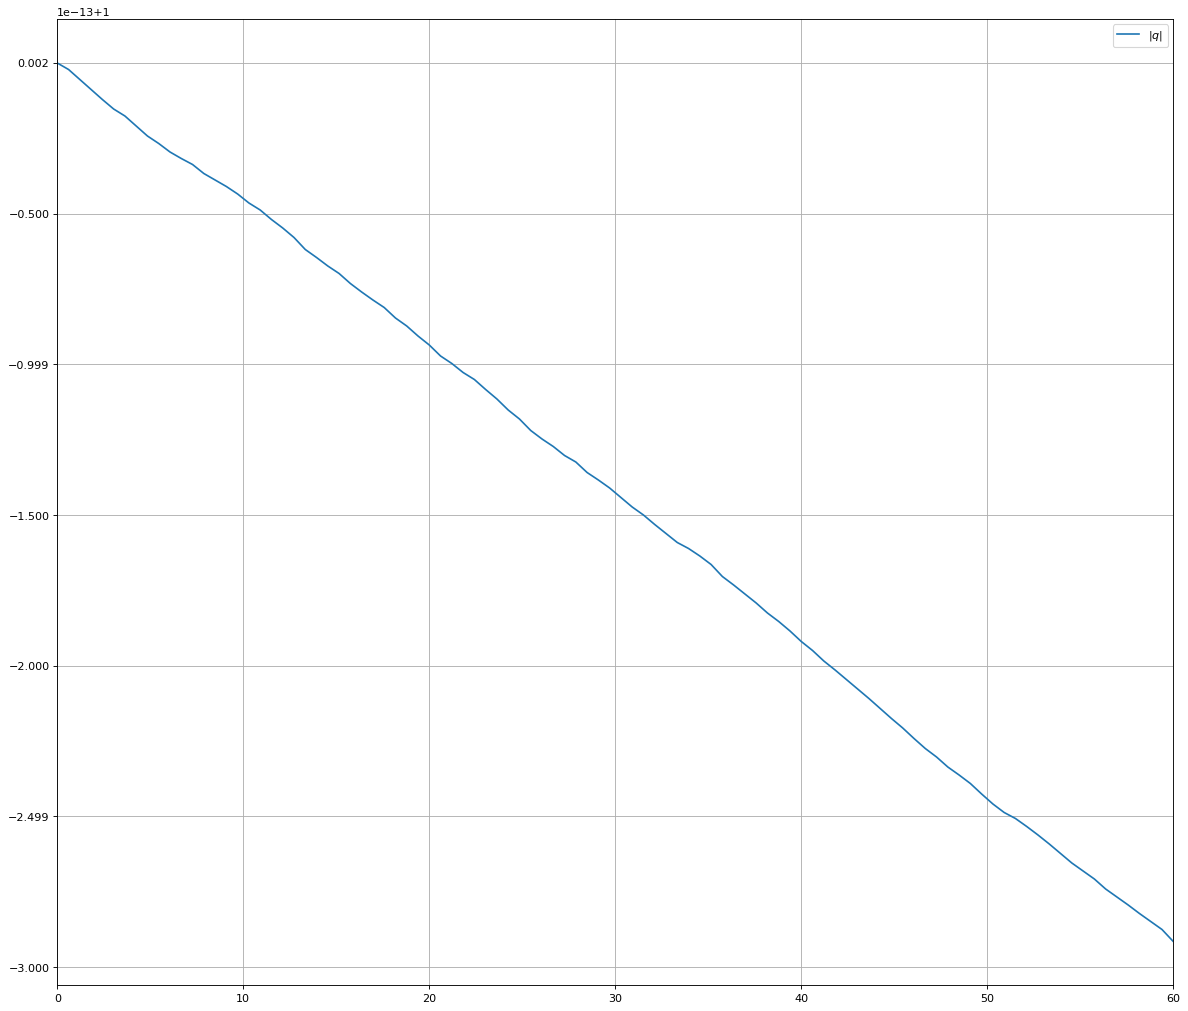

In [17]:
l = ["$|q|$"]

fig= plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(ts, np.linalg.norm(us[:, :], axis=1), label=l[0])
plt.xlim([0e0, 60e0])
plt.grid(True)
plt.legend()

plt.show()